# Applied Homework


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
import itertools
from IPython.display import display, HTML
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import sklearn.metrics as metrics

dir='/Users/shuya/Documents/DS/MachineLearning/Statistical Learning/Data/'

import warnings
warnings.filterwarnings('ignore')

## Question 8


8(a) Generate a normally distributed predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [3]:
mu,sigma = 0,1
x = np.random.normal(mu,sigma,100)
noise = np.random.normal(mu,sigma,100)

8(b)Generate a response vector Y of length n = 100 according to the model

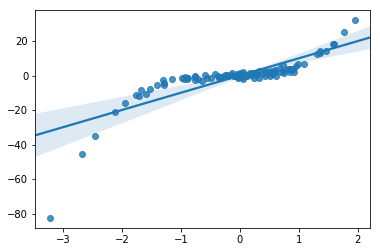

In [3]:
beta1,beta2,beta3=1,2,3
y = beta1*x+beta2*(x**2)+beta3*(x**3)+noise

#Visualize the relationship between x and y
sns.regplot(x=x,y=y)

(c) Perform best subset selection in order to choose the best model containing the predictors X, X2, . . . , X10. What is the best model obtained according to Cp, BIC, and adjusted R2? Show some plots to provide evidence for your answer, and report the coefficients of the best model ob- tained. Note you will need to use the data.frame() function to create a single data set containing both X and Y .

In [4]:
#Construct dataset with X to X^10
reg_data = pd.DataFrame(np.c_[x,y],columns=['x','y'])
for i in range(2,11,1):
    reg_data['x^'+str(i)] = reg_data['x'].apply(lambda x:x**i)
    
reg_data.head()

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
0,0.847348,2.287577,0.717999,0.608395,0.515523,4.368274e-01,3.701450e-01,3.136417e-01,2.657638e-01,2.251945e-01,1.908182e-01
1,0.729922,2.610515,0.532786,0.388893,0.283861,2.071968e-01,1.512375e-01,1.103916e-01,8.057731e-02,5.881517e-02,4.293050e-02
2,1.775921,25.507168,3.153897,5.601074,9.947067,1.766521e+01,3.137202e+01,5.571425e+01,9.894414e+01,1.757170e+02,3.120596e+02
3,0.329460,-1.205858,0.108544,0.035761,0.011782,3.881608e-03,1.278833e-03,4.213241e-04,1.388093e-04,4.573208e-05,1.506688e-05
4,0.048572,0.868252,0.002359,0.000115,0.000006,2.703605e-07,1.313203e-08,6.378531e-10,3.098199e-11,1.504866e-12,7.309482e-14


In [57]:
X = reg_data.drop(['y'],axis=1)
X.shape

(100, 10)

In [7]:
def subset_reg(X,y,k):
    X_combos = itertools.combinations(list(X.columns), k)
    max_rsquare=0
    min_bic=99999999
    min_aic=99999999
    
    for combo in X_combos:
        X_new=X[list(combo)]
        model=sm.OLS(y,sm.add_constant(X_new)).fit()
        if model.rsquared_adj>max_rsquare:
            max_rsquare=model.rsquared_adj
            max_rsquare_model=model
            
        if model.bic<min_bic:
            min_bic=model.bic
            min_bic_model=model
            
        if model.aic<min_bic:
            min_aic=model.bic
            min_aic_model=model
            
    return {'max adj.Rsquare':max_rsquare,
            'max adj.Rsquare model':max_rsquare_model,
            'min BIC':min_bic,
            'min BIC model':min_bic_model,
            'min AIC':min_aic,
            'min AIC model':min_aic_model
           }



In [ ]:
subset_reg(X,y,5)['min AIC model'].params

In [110]:
adj_R=[]
BIC=[]
AIC=[]

for i in range(1,X.shape[1]+1,1):
    adj_R.append([i,subset_reg(X,y,i)['max adj.Rsquare']])
    BIC.append([i,subset_reg(X,y,i)['min BIC']])
    AIC.append([i,subset_reg(X,y,i)['min AIC']])

adj_R = pd.DataFrame(adj_R,columns=['i','adj.R'])
BIC = pd.DataFrame(BIC,columns=['i','BIC'])
AIC = pd.DataFrame(AIC,columns=['i','AIC'])

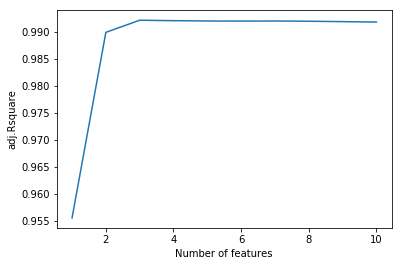

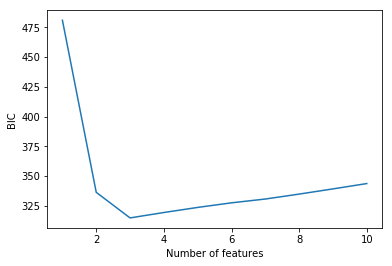

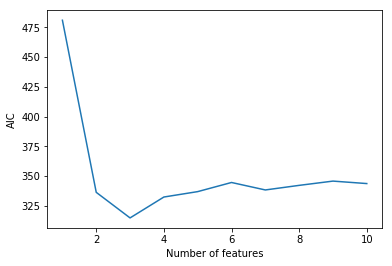

In [117]:
display(HTML('<h4>adj Rsquare</h4>'))

plt.plot(adj_R['i'],adj_R['adj.R'])
plt.xlabel('Number of features')
plt.ylabel('adj.Rsquare')
plt.show()

display(HTML('<h4>BIC</h4>'))

plt.plot(BIC['i'],BIC['BIC'])
plt.xlabel('Number of features')
plt.ylabel('BIC')
plt.show()

display(HTML('<h4>AIC</h4>'))

plt.plot(AIC['i'],AIC['AIC'])
plt.xlabel('Number of features')
plt.ylabel('AIC')
plt.show()

(d) Repeat (c), using forward stepwise selection and also using backwards
stepwise selection. How does your answer compare to the
results in (c)?


In [141]:
X=pd.DataFrame([[x,y,z] for x,y,z in zip(x,x**2,x**3)])

import statsmodels.api as sm
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Add                               2 with p-value 3.99383e-62
Add                               1 with p-value 4.81245e-44
Add                               0 with p-value 9.99812e-08
resulting features:
[2, 1, 0]


(e) Now fit a lasso model to the simulated data, again using X,X2,
. . . , X10 as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.

https://www.kaggle.com/floser/aw6-the-lasso-cross-validated

(50,)
[2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 2881.363217815752, 1286.226392933291, 574.5064493557342, 306.86237262089867, 169.6121506749483, 96.6923042137942, 56.484219895107486, 36.17891094187447, 26.050194745742616, 20.893764811515364, 18.201712277607406, 16.753431981549276, 15.9470002340921, 15.513771944514522, 15.334136015159888, 15.226579195290805]


Text(0, 0.5, 'weights')

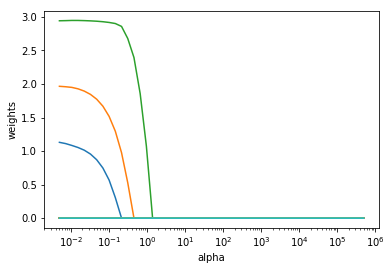

In [169]:
X=pd.DataFrame([[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10] for x1,x2,x3,x4,x5,x6,x7,x8,x9,x10 \
                in zip(x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9,x**10)])
from sklearn import model_selection
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

x_train,x_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2,random_state=3)

alphas = 10**np.linspace(6,-2,50)*0.5
lasso = Lasso(max_iter=10000, normalize=True)
coef=[]
SS_Residual=[]
print(alphas.shape)

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train,y_train)
    coef.append(lasso.coef_)
    resid=lasso.predict(x_test)-y_test
    SS_Residual.append(sum(resid**2))

print(SS_Residual)    
ax = plt.gca()
ax.plot(alphas, coef)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

(f) Now generate a response vector Y according to the model
Y = β0 + β7X^7 + ϵ,
and perform best subset selection and the lasso. Discuss the
results obtained.

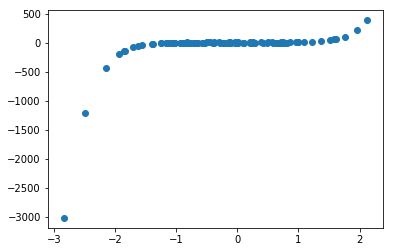

In [22]:
mu,sigma=0,1
beta1,beta7=1,2

x = np.random.normal(mu,sigma,100)
noise = np.random.normal(mu,sigma,100)
y = beta1+beta7*(x**7)+noise

plt.scatter(x,y)

In [20]:
np.arange(7)

array([0, 1, 2, 3, 4, 5, 6])

In [32]:
X = pd.DataFrame(x.copy())
for i in np.arange(7):
    X['x^'+str(i)] = x**i

X.head()

,0,x^0,x^1,x^2,x^3,x^4,x^5,x^6
0,-2.844826,1.0,-2.844826,8.093037,-2.302329e+01,6.549725e+01,-1.863283e+02,5.300717e+02
1,0.759667,1.0,0.759667,0.577094,4.383991e-01,3.330373e-01,2.529974e-01,1.921938e-01
2,-1.171460,1.0,-1.171460,1.372318,-1.607615e+00,1.883257e+00,-2.206160e+00,2.584428e+00
3,-0.019338,1.0,-0.019338,0.000374,-7.231851e-06,1.398511e-07,-2.704472e-09,5.229967e-11
4,0.003084,1.0,0.003084,0.000010,2.932502e-08,9.043109e-11,2.788671e-13,8.599568e-16


In [38]:
subset_reg(X,y,7)

{'max adj.Rsquare': 0.9991402833377621,
 'max adj.Rsquare model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c245ea7b8>,
 'min BIC': 763.3795320919711,
 'min BIC model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c245ea438>,
 'min AIC': 763.3795320919711,
 'min AIC model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c245ea438>}

In [39]:
subset_reg(X,y,3)['min AIC model'].params

const     0.846509
x^1      49.327009
x^3     -75.716660
x^5      24.438487
dtype: float64

In [47]:
clf = Lasso(alpha=0.1, normalize=True)
clf.fit(X,y)
clf.coef_

array([  0.        ,   0.        ,   0.        ,   3.8209004 ,
       -17.59596138,   9.73278429,  12.93118752,  -3.00627012])

## Question 9

In this exercise, we will predict the number of applications received
using the other variables in the College data set.

(a) Split the data set into a training set and a test set.

In [154]:
from sklearn.model_selection import train_test_split
college = pd.read_csv(dir+'College.csv',index_col='Unnamed: 0')
college.Private = college.Private.map({'Yes':1,'No':0})
print(college.head())
X_train,X_test,y_train,y_test=train_test_split(college.drop(['Apps'],axis=1),college['Apps'],train_size=0.5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,type(y_test))
X_train.shape

                              Private  Apps  Accept  Enroll  Top10perc  \
Abilene Christian University        1  1660    1232     721         23   
Adelphi University                  1  2186    1924     512         16   
Adrian College                      1  1428    1097     336         22   
Agnes Scott College                 1   417     349     137         60   
Alaska Pacific University           1   193     146      55         16   

                              Top25perc  F.Undergrad  P.Undergrad  Outstate  \
Abilene Christian University         52         2885          537      7440   
Adelphi University                   29         2683         1227     12280   
Adrian College                       50         1036           99     11250   
Agnes Scott College                  89          510           63     12960   
Alaska Pacific University            44          249          869      7560   

                              Room.Board  Books  Personal  PhD  Terminal  \
Abil

(388, 17)

(b) Fit a linear model using least squares on the training set, and
report the test error obtained.

In [67]:
def subset_reg(X_train,y_train,X_test,y_test,k):
    X_combos = itertools.combinations(list(X_train.columns), k)
    min_mse=9999999
    
    for combo in X_combos:
        X_train_new = X_train[list(combo)]
        X_test_new = X_test[list(combo)]        
        model = sm.OLS(y_train,sm.add_constant(X_train_new)).fit()        
        pred = model.predict(sm.add_constant(X_test_new))       
        mse = metrics.mean_squared_error(y_test,pred)
    
        if mse < min_mse:
            min_mse=mse
            best_model=model

            
    return {'min mse':min_mse,
            'best model':best_model
           }

In [135]:
mse = []
for i in range(1,X_train.shape[1]+1,1):
    mse.append([i,subset_reg(X_train,y_train,X_test,y_test,i)['min mse']])
mse_df = pd.DataFrame(mse,columns=['i','mse'])

     i           mse
0    1  1.578334e+06
1    2  1.268801e+06
2    3  1.249164e+06
3    4  1.247772e+06
4    5  1.245488e+06
5    6  1.244394e+06
6    7  1.245730e+06
7    8  1.246639e+06
8    9  1.250910e+06
9   10  1.258172e+06
10  11  1.269936e+06
11  12  1.272338e+06
12  13  1.285562e+06
13  14  1.337975e+06
14  15  1.401283e+06
15  16  1.455809e+06
16  17  1.503133e+06


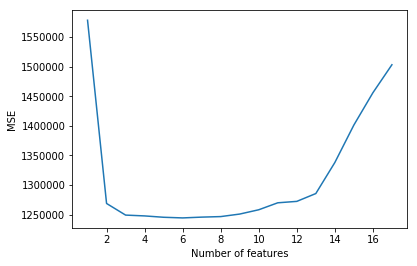

In [138]:
print(mse_df)

sns.lineplot(x=mse_df['i'],y=mse_df['mse'])
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.show()

In [68]:
#6 variable produce the smallest MSE

best_subset=pd.DataFrame(subset_reg(X_train,y_train,X_test,y_test,8)['best model'].params)

print('the mse is {}'.format(subset_reg(X_train,y_train,X_test,y_test,8)['min mse']))
print('the rmse is {}'.format(np.sqrt(subset_reg(X_train,y_train,X_test,y_test,8)['min mse'])))

the mse is 1298034.1995682262
the rmse is 1139.31303844388


(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.

In [194]:
alphas=10**np.linspace(-10,1.5,50)
print(alphas)

[1.00000000e-10 1.71669791e-10 2.94705170e-10 5.05919749e-10
 8.68511374e-10 1.49097166e-09 2.55954792e-09 4.39397056e-09
 7.54312006e-09 1.29492584e-08 2.22299648e-08 3.81621341e-08
 6.55128557e-08 1.12465782e-07 1.93069773e-07 3.31442475e-07
 5.68986603e-07 9.76778110e-07 1.67683294e-06 2.87861559e-06
 4.94171336e-06 8.48342898e-06 1.45634848e-05 2.50011038e-05
 4.29193426e-05 7.36795456e-05 1.26485522e-04 2.17137430e-04
 3.72759372e-04 6.39915234e-04 1.09854114e-03 1.88586328e-03
 3.23745754e-03 5.55773659e-03 9.54095476e-03 1.63789371e-02
 2.81176870e-02 4.82695744e-02 8.28642773e-02 1.42252931e-01
 2.44205309e-01 4.19226744e-01 7.19685673e-01 1.23548289e+00
 2.12095089e+00 3.64103195e+00 6.25055193e+00 1.07303094e+01
 1.84206997e+01 3.16227766e+01]


In [106]:
X.shape
rec=np.linspace(0,X.shape[0],5,dtype=int)
folds = [[rec[n],rec[n+1]] for n in np.arange(4)]
X = college.drop(['Apps'],axis=1)
print(folds)
X.iloc[folds[0][0]:folds[0][1]]
X_train = X.drop(X.index[folds[0][0]:folds[0][1]])
#print(X_train)

[[0, 194], [194, 388], [388, 582], [582, 777]]


In [130]:
def ridge_cv(alpha, X, y, k):
    rec = np.linspace(0,X.shape[1],k,dtype=int)
    folds = [[rec[n],rec[n+1]] for n in np.arange(k-1)]
    mse=[]
    for f in folds:
        X_test = X.iloc[f[0]:f[1]]
        X_train = X.drop(X.index[f[0]:f[1]])
        y_test = y.iloc[f[0]:f[1]]
        y_train = y.drop(y.index[f[0]:f[1]])
        rm = Ridge(alpha=alpha, normalize=True)
        rm.fit(X_train,y_train)
        pred = rm.predict(X_test)
        mse.append(metrics.mean_squared_error(y_test,pred))
    return np.mean(mse)

In [142]:
mse = []
for alpha in (10**(np.linspace(0,6,100)))**(-1):
    mse.append([alpha,ridge_cv(alpha,college.drop(['Apps'],axis=1),college['Apps'],5)])
mse = pd.DataFrame(mse,columns=['alpha','mse'])

the lowst mse is 323438.0140124246
the lowst rmse is 568.716110210028


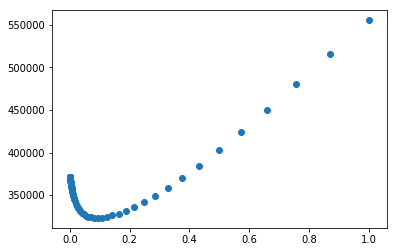

In [151]:
#print(mse)
plt.scatter(x=mse['alpha'],y=mse['mse'])
print('the lowst mse is {}'.format(ridge_cv(0.1,college.drop(['Apps'],axis=1),college['Apps'],5)))
print('the lowst rmse is {}'.format(np.sqrt(ridge_cv(0.1,college.drop(['Apps'],axis=1),college['Apps'],5))))

In [160]:
ridgeCV = RidgeCV(normalize=True,alphas=alphas)
ridgeCV.fit(X_train,y_train)
#print(ridgeCV.get_params())

ridge_results=pd.DataFrame(np.c_[X_train.columns,ridgeCV.coef_],columns=['variable','coefficient'])
print(ridge_results)

pred = ridgeCV.predict(X_test)
mse = metrics.mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
print("the chosen lambda is {0:0.4f}, the mse is {1:0.4f},the rmse is {2:0.4f}, ".format(ridgeCV.alpha_,mse,rmse))

       variable coefficient
0       Private    -618.394
1        Accept     1.32295
2        Enroll   -0.705586
3     Top10perc     41.8825
4     Top25perc    -10.2464
5   F.Undergrad    0.102292
6   P.Undergrad   0.0252067
7      Outstate  -0.0593363
8    Room.Board    0.273835
9         Books   0.0451096
10     Personal   0.0759682
11          PhD    -2.48482
12     Terminal    -4.01459
13    S.F.Ratio      2.2244
14  perc.alumni    -8.73709
15       Expend   0.0517115
16    Grad.Rate     9.50877
the chosen lambda is 0.0032, the mse is 1600849.1205,the rmse is 1265.2467, 


(d) Fit a lasso model on the training set, with λ chosen by crossvalidation.
Report the test error obtained, along with the number
of non-zero coefficient estimates.

In [163]:
def lasso_cv(alpha, X, y, k):
    rec = np.linspace(0,X.shape[1],k,dtype=int)
    folds = [[rec[n],rec[n+1]] for n in np.arange(k-1)]
    mse=[]
    for f in folds:
        X_test = X.iloc[f[0]:f[1]]
        X_train = X.drop(X.index[f[0]:f[1]])
        y_test = y.iloc[f[0]:f[1]]
        y_train = y.drop(y.index[f[0]:f[1]])
        rm = Lasso(alpha=alpha, normalize=True)
        rm.fit(X_train,y_train)
        pred = rm.predict(X_test)
        mse.append(metrics.mean_squared_error(y_test,pred))
    return np.mean(mse)

print(lasso_cv(0.1,college.drop(['Apps'],axis=1),college['Apps'],5))        

364004.22129842255


        alpha            mse
0    0.001000  371537.566066
1    0.001624  371479.546837
2    0.002637  371385.594020
3    0.004281  371225.940470
4    0.006952  370953.581746
5    0.011288  370512.941637
6    0.018330  369808.729494
7    0.029764  368730.232680
8    0.048329  367310.814577
9    0.078476  365342.744736
10   0.127427  362371.141123
11   0.206914  357922.803955
12   0.335982  351681.381952
13   0.545559  347391.774135
14   0.885867  345274.134510
15   1.438450  339192.916029
16   2.335721  350814.595524
17   3.792690  350525.251349
18   6.158482  363003.217300
19  10.000000  374645.716183


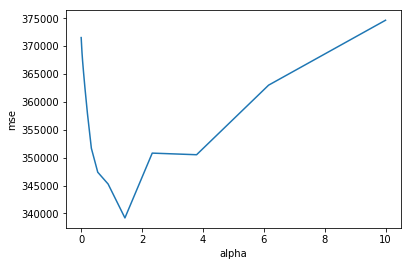

In [165]:
alphas=10**np.linspace(-3,1,20)
mse=[]
for a in alphas:
    mse.append([a,lasso_cv(a,college.drop(['Apps'],axis=1),college['Apps'],5)])

    
mse_df = pd.DataFrame(mse,columns = ['alpha','mse'])    
print(mse_df) 
sns.lineplot(x = mse_df['alpha'],y = mse_df['mse'])

In [169]:
lasso_best = Lasso(max_iter = 10000, normalize = True)
lasso_best.set_params(alpha = 1.5)
lasso_best.fit(X_train,y_train)

pred = lasso_best.predict(X_test)
print(metrics.mean_squared_error(y_test,pred))
print('the rmse is {}'.format(np.sqrt(metrics.mean_squared_error(y_test,pred))))


lasso_results=pd.DataFrame(np.c_[college.drop(['Apps'],axis=1).columns,lasso_best.coef_],columns=['variable','coefficient'])
print(lasso_results)

1732850.6078417338
the rmse is 1316.3778362771586
       variable coefficient
0       Private    -559.483
1        Accept     1.22734
2        Enroll          -0
3     Top10perc     27.5226
4     Top25perc          -0
5   F.Undergrad  0.00870371
6   P.Undergrad   0.0320932
7      Outstate  -0.0281151
8    Room.Board    0.214308
9         Books           0
10     Personal   0.0204909
11          PhD          -0
12     Terminal    -1.58169
13    S.F.Ratio           0
14  perc.alumni    -9.15115
15       Expend   0.0400632
16    Grad.Rate     5.34158


In [220]:
#Compare the results between lasso and ridge
dfs = [ridge_results, lasso_results]
nan_value = 0

result_1 = pd.concat(dfs, join='outer', axis=1).fillna(nan_value)
print(result_1)

       variable  coefficient     variable  coefficient
0       Private  -767.879695      Private  -357.240352
1        Accept     1.095505       Accept     1.394018
2        Enroll     0.315133       Enroll    -0.000000
3     Top10perc    55.172602    Top10perc    28.452240
4     Top25perc   -14.571498    Top25perc    -0.000000
5   F.Undergrad     0.044544  F.Undergrad    -0.000000
6   P.Undergrad    -0.052121  P.Undergrad     0.000000
7      Outstate    -0.046914     Outstate    -0.038492
8    Room.Board     0.254205   Room.Board     0.100573
9         Books     0.174463        Books     0.000000
10     Personal    -0.080789     Personal     0.000000
11          PhD    -3.993597          PhD    -3.499813
12     Terminal    -6.720735     Terminal    -2.728283
13    S.F.Ratio   -14.059730    S.F.Ratio     0.000000
14  perc.alumni   -11.962541  perc.alumni    -0.735669
15       Expend     0.042297       Expend     0.062284
16    Grad.Rate    11.179702    Grad.Rate     3.200387


(e) Fit a PCR model on the training set, with M chosen by crossvalidation.
Report the test error obtained, along with the value
of M selected by cross-validation.

In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
pca = PCA()
X_reduced = pca.fit_transform(scale(X_train))
print(X_reduced.shape,X_train.shape,X_reduced)

(388, 17) (388, 17) [[ 4.85225698e+00  2.62223463e-01 -3.67041070e-03 ...  1.11162555e-01
   3.25738523e-01 -9.57630000e-02]
 [-2.72200392e+00  1.38783073e+00 -6.75008339e-01 ...  8.47251704e-02
  -4.76652203e-01 -2.03036865e-01]
 [-2.19220126e+00 -6.83124531e-01 -5.21337622e-01 ... -4.00748442e-03
  -3.21631693e-02 -2.51236541e-02]
 ...
 [ 4.46518750e-02 -1.26345979e+00 -3.89525272e-01 ...  6.15731795e-02
   1.51926305e-02 -4.52795438e-02]
 [-1.40777935e-01 -7.75868597e-01 -4.80029234e-01 ...  1.54944743e-01
  -1.77632161e-01 -2.82425523e-02]
 [-2.36909731e-01 -6.05985889e-01  1.28277333e-01 ...  2.00436387e-01
   2.14006795e-01 -1.62010766e-02]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


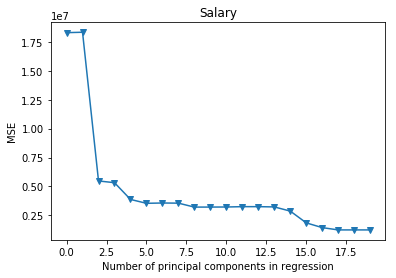

In [95]:
# 10-fold CV, with shuffle
y = y_train
n = len(X_reduced)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);


(f) Fit a PLS model on the training set, with M chosen by crossvalidation.
Report the test error obtained, along with the value
of M selected by cross-validation.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[

(-1, 16.75)

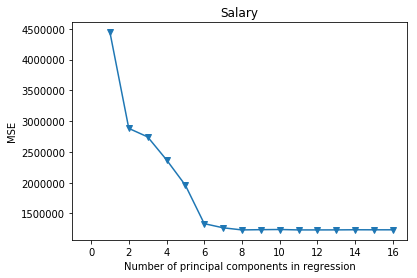

In [98]:
from sklearn.cross_decomposition import PLSRegression, PLSSVD

n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 17):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 17), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

(g) Comment on the results obtained. How accurately can we predict
the number of college applications received? Is there much
difference among the test errors resulting from these five approaches?

## Question 10

10. We have seen that as the number of features used in a model increases,
the training error will necessarily decrease, but the test error may not.
We will now explore this in a simulated data set.

(a) Generate a data set with p = 20 features, n = 1,000 observations,
and an associated quantitative response vector generated
according to the model

> Y = Xβ + ϵ

where β has some elements that are exactly equal to zero.

In [223]:
X=pd.DataFrame(np.random.rand(1000,20))
print(X.shape)
beta=np.random.randn(20)
beta[1]=0
beta[3]=0
beta[9]=0
beta[15]=0
beta[18]=0

print(beta)

y = pd.DataFrame(X.dot(beta)+np.random.randn(1000))
df = pd.concat((X,y),axis=1)
df.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','y']
df.head()

(1000, 20)
[ 0.29965563  0.          0.44398052  0.         -1.44534466 -0.21937014
 -0.5324188   0.41158032 -0.95270241  0.         -0.09496684 -1.45650564
  0.25130975 -1.7101918  -0.15649875  0.         -0.28838207  0.616903
  0.         -1.55999546]


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,0.486366,0.862608,0.368073,0.346024,0.392613,0.482711,0.041422,0.119815,0.038691,0.051508,...,0.627131,0.170232,0.350450,0.202352,0.279007,0.621802,0.526848,0.845065,0.956587,-2.132457
1,0.999579,0.707782,0.802784,0.205669,0.336560,0.907955,0.317275,0.253394,0.046451,0.600301,...,0.952959,0.694124,0.512350,0.198450,0.836660,0.155924,0.922226,0.252259,0.798829,-3.134455
2,0.529945,0.522897,0.165718,0.000721,0.507074,0.074480,0.623724,0.281444,0.058290,0.280462,...,0.227531,0.310586,0.904893,0.525261,0.692215,0.681984,0.163067,0.275909,0.301024,-4.681402
3,0.760893,0.134159,0.780079,0.047360,0.735424,0.712769,0.468172,0.454209,0.261404,0.299572,...,0.157368,0.620453,0.018439,0.070403,0.600197,0.791067,0.061694,0.400241,0.550583,-3.674077
4,0.514750,0.143211,0.821142,0.787705,0.277122,0.436206,0.030242,0.883372,0.250017,0.230151,...,0.584172,0.736120,0.279303,0.191108,0.220532,0.993609,0.625884,0.770179,0.910357,-2.769262


(b) Split your data set into a training set containing 100 observations
and a test set containing 900 observations.

In [224]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df.drop(['y'],axis=1),df['y'],train_size=100)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(100, 20) (100,) (900, 20) (900,)


(c) Perform best subset selection on the training set, and plot the
training set MSE associated with the best model of each size.

In [226]:
def subset_reg(X_train,y_train,X_test,y_test,k):
    X_combos = itertools.combinations(list(X_train.columns), k)
    min_mse_train = 9999999
    min_mse_test = 99999999
    
    for combo in X_combos:
        X_train_new = X_train[list(combo)]
        X_test_new = X_test[list(combo)]        
        model = sm.OLS(y_train,sm.add_constant(X_train_new)).fit()        
        pred = model.predict(sm.add_constant(X_test_new))       
        mse_test = ((y_test-pred)**2).mean()
        pred_train = model.predict(sm.add_constant(X_train_new))
        mse_train = ((y_train-pred_train)**2).mean()
        
        if mse_test < min_mse_test:
            min_mse_test = mse_test
            best_model_test = model
            
        if mse_train < min_mse_train:
            min_mse_train = mse_train
            best_model_train = model

            
    return {'min mse train':min_mse_train,
            'best model train':best_model_train,
            'min mse test':min_mse_test,
            'best model test':best_model_test
           }



print(subset_reg(X_train,y_train,X_test,y_test,5)['min mse train'])

0.9832780343811425


In [ ]:
mse_train=[]
mse_test=[]
for i in range(1,21,1):
    mse_train.append([i,subset_reg(X_train,y_train,X_test,y_test,i)['min mse train']])
    mse_test.append([i,subset_reg(X_train,y_train,X_test,y_test,i)['min mse test']])

df_mse_train=pd.DataFrame(mse_train,columns=['size','mse'])
df_mse_test=pd.DataFrame(mse_test,columns=['size','mse'])

(d) Plot the test set MSE associated with the best model of each
size.

In [ ]:
sns.lineplot(x = mse_train['size'], y = mse_train['mse'])
plt.show()

sns.lineplot(x = mse_test['size'], y = mse_test['mse'])
plt.show()


## Questions 11